<a href="https://colab.research.google.com/github/VIVEK-JADHAV/TweetSentimentExtraction/blob/master/Roberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS 
import re 
import string
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input,Flatten,Embedding,Lambda,Dropout,LSTM,Conv1D,Concatenate,Add
from tensorflow.keras.models import Model
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
import keras.backend as K


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Creating a folder to store train and test data
import os
os.mkdir('/content/data')
%cd /content/data/
!pwd

/content/data
/content/data


In [ ]:
!kaggle competitions download -c tweet-sentiment-extraction

  0% 0.00/1.23M [00:00<?, ?B/s]
100% 1.23M/1.23M [00:00<00:00, 40.6MB/s]
  0% 0.00/307k [00:00<?, ?B/s]
100% 307k/307k [00:00<00:00, 95.1MB/s]
  0% 0.00/41.4k [00:00<?, ?B/s]
100% 41.4k/41.4k [00:00<00:00, 40.2MB/s]


In [ ]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [ ]:
#Loading the train dataset

train=pd.read_csv('/content/data/train.csv')
print('Shape of the train data is ',train.shape)
train.head()

Shape of the train data is  (27481, 4)


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
#Loading the test dataset

test=pd.read_csv('/content/data/test.csv')
print('Shape of the test data is ',test.shape)
test.head()

Shape of the test data is  (3534, 3)


,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [ ]:
#Dropping the row with null value
train.dropna(inplace=True)
train.reset_index(inplace=True,drop=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27480 entries, 0 to 27479
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [ ]:
!pip install transformers

     |████████████████████████████████| 890kB 8.1MB/s 
     |████████████████████████████████| 1.1MB 28.7MB/s 
     |████████████████████████████████| 890kB 53.7MB/s 
     |████████████████████████████████| 3.0MB 47.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=5aeb66cf2e8a434ee4330973318eb1eb9505f9aed2b2606c75ff3b45018cfd69
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
#Importing the config,tokenizer and Roberta model

from transformers import  RobertaConfig, TFRobertaModel
from tokenizers import ByteLevelBPETokenizer

In [ ]:
#Downloading the vocab and merge file for tokenizer
!wget "https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-vocab.json"
!wget "https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-merges.txt"

--2020-09-05 03:13:36--  https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-vocab.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.78.86
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.78.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 898823 (878K) [application/json]
Saving to: ‘roberta-base-vocab.json’

roberta-base-vocab. 100%[===================>] 877.76K  1.68MB/s    in 0.5s    

2020-09-05 03:13:36 (1.68 MB/s) - ‘roberta-base-vocab.json’ saved [898823/898823]

--2020-09-05 03:13:37--  https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-merges.txt
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.81.198
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.81.198|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 456318 (446K) [text/plain]
Saving to: ‘roberta-base-merges.txt’

roberta-base-merges 100%[===================>] 445.62K  1.27MB/s    in 0.3s    

2020-09-05 03:13:

In [ ]:
#Setting the global variables
MAX_LEN = 96
tokenizer = ByteLevelBPETokenizer(
    vocab_file='/content/data/roberta-base-vocab.json', 
    merges_file='/content/data/roberta-base-merges.txt', 
    lowercase=True,
    add_prefix_space=True,
)
#Setting the sentiment_id dictionary with its token values
sentiment_id = {'positive': 1313, 'negative': 2430, 'neutral': 7974}

In [ ]:
#Perform train,validation and test split

from sklearn.model_selection import train_test_split

X_train,X_val,Y_train,Y_val=train_test_split(train,train['sentiment'],
                                              test_size=0.2,random_state=42,stratify=train['sentiment'])
X_train,X_test,Y_train,Y_test=train_test_split(X_train,Y_train,
                                               test_size=0.2,random_state=42,stratify=X_train['sentiment'])

X_train.reset_index(inplace=True,drop=True)
X_val.reset_index(inplace=True,drop=True)
X_test.reset_index(inplace=True,drop=True)

Y_train=Y_train.reset_index(drop=True)
Y_val=Y_val.reset_index(drop=True)
Y_test=Y_test.reset_index(drop=True)

print('X_train shape',X_train.shape,' Y_train shape ',Y_train.shape)
print('X_val shape',X_val.shape,' Y_val shape ',Y_val.shape)
print('X_test shape',X_test.shape,' Y_test shape ',Y_test.shape)

X_train shape (17587, 4)  Y_train shape  (17587,)
X_val shape (5496, 4)  Y_val shape  (5496,)
X_test shape (4397, 4)  Y_test shape  (4397,)


In [ ]:
#Reference: https://www.kaggle.com/cdeotte/tensorflow-roberta-0-705

def createInputData(data,tokenizer):

  row = data.shape[0]
  input_ids = np.ones((row,MAX_LEN),dtype='int32')
  attention_mask = np.zeros((row,MAX_LEN),dtype='int32')
  token_type_ids = np.zeros((row,MAX_LEN),dtype='int32')
  start_tokens = np.zeros((row,MAX_LEN),dtype='int32')
  end_tokens = np.zeros((row,MAX_LEN),dtype='int32')

  for k in range(data.shape[0]):
      
    #Finding the index of selected text in text
    text1 = " "+" ".join(data.loc[k,'text'].split())
    text2 = " ".join(data.loc[k,'selected_text'].split())
    idx = text1.find(text2)

    #Setting the a list with 1 where selected text is present
    chars = np.zeros((len(text1)))
    chars[idx:idx+len(text2)]=1

    if text1[idx-1]==' ': 
      chars[idx-1] = 1 

    enc = tokenizer.encode(text1) 
        
    #Finding the offsets
    token_offsets=[]
    idx=0
    for i in enc.ids:
      word=tokenizer.decode([i])
      token_offsets.append((idx,idx+len(word)))
      idx+=len(word)
    
    
    # Setting the start and end tokens
    target_idx = []
    for i,(o1,o2) in enumerate(token_offsets):
      if(sum(chars[o1:o2])>0):
        target_idx.append(i) 
        
    s_tok = sentiment_id[data.loc[k,'sentiment']]

    input_ids[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_tok] + [2]
    attention_mask[k,:len(enc.ids)+5] = 1

    #Adding 1 to account for [0] token
    if len(target_idx)>0:
      start_tokens[k,target_idx[0]+1] = 1
      end_tokens[k,target_idx[-1]+1] = 1

  return (input_ids,attention_mask,token_type_ids,start_tokens,end_tokens)

In [ ]:
#Convert train,validation and test data to Roberta input
X_tr1,X_tr2,X_tr3,Y_tr1,Y_tr2=createInputData(X_train,tokenizer)
X_val1,X_val2,X_val3,Y_val1,Y_val2=createInputData(X_val,tokenizer)
X_te1,X_te2,X_te3,Y_te1,Y_te2=createInputData(X_test,tokenizer)

In [ ]:
#Checking the shapes 
print('The shape of token ids',X_tr1.shape)
print('The shape of attention mask ',X_tr2.shape)
print('The shape of token type ids',X_tr3.shape)
print('The shape of start tokens',Y_tr1.shape)
print('The shape of end tokens',Y_tr2.shape)

The shape of token ids (17587, 96)
The shape of attention mask  (17587, 96)
The shape of token type ids (17587, 96)
The shape of start tokens (17587, 96)
The shape of end tokens (17587, 96)


In [ ]:
#Model Archietecture
def build_model():
  '''Builds the model'''

  ids=Input((MAX_LEN),name='ids',dtype='int32')
  att_mask=Input((MAX_LEN),name='att_mask',dtype='int32')
  type_ids=Input((MAX_LEN),name='type_ids',dtype='int32')

  roberta_conf = RobertaConfig.from_pretrained('roberta-base')
  roberta_model = TFRobertaModel.from_pretrained('roberta-base',config=roberta_conf)
  
  bert_output=roberta_model([ids,att_mask,type_ids])

  dropout1=Dropout(0.1,name='dropout1')(bert_output[0])
  conv1d_1 = Conv1D(1,1,kernel_initializer=tf.keras.initializers.glorot_uniform(seed=20),name='conv1d_1')(dropout1)
  flatten_1 = Flatten(name='flatten_1')(conv1d_1)
  out_1 = tf.keras.layers.Activation('softmax',name='activation1')(flatten_1)

  dropout2=Dropout(0.1,name='dropout2')(bert_output[0])
  conv1d_2 = Conv1D(1,1,kernel_initializer=tf.keras.initializers.glorot_uniform(seed=20),name='conv1d_2')(dropout2)
  flatten_2 = Flatten(name='flatten_2')(conv1d_2)
  out_2 = tf.keras.layers.Activation('softmax',name='activation2')(flatten_2)

  model1 = Model(inputs=[ids, att_mask, type_ids], outputs=[out_1,out_2])

  return model1
  
model1=build_model()

Some weights of the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
model1.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ids (InputLayer)                [(None, 96)]         0                                            
__________________________________________________________________________________________________
att_mask (InputLayer)           [(None, 96)]         0                                            
__________________________________________________________________________________________________
type_ids (InputLayer)           [(None, 96)]         0                                            
__________________________________________________________________________________________________
tf_roberta_model_1 (TFRobertaMo ((None, 96, 768), (N 124645632   ids[0][0]                        
                                                                 att_mask[0][0]        

Model Archietecture
* Input Layer: 3 input layers: 
  * Input_ids: Numeric ids of each token with [1] as pad token
  * Attention_mask: It has 1 for tokens and 0 for other
  * Token_type ids: Ih has 0 for all as there are only one type
* Roberta Model: It returns a 768 dimensional vector for each token
* Conv1D: 2 Conv1D layers, one for start and other for end scores. It has kernal size of 1 and 1 filter.
* OutputLayer: Softmax activation applied to start and end scores

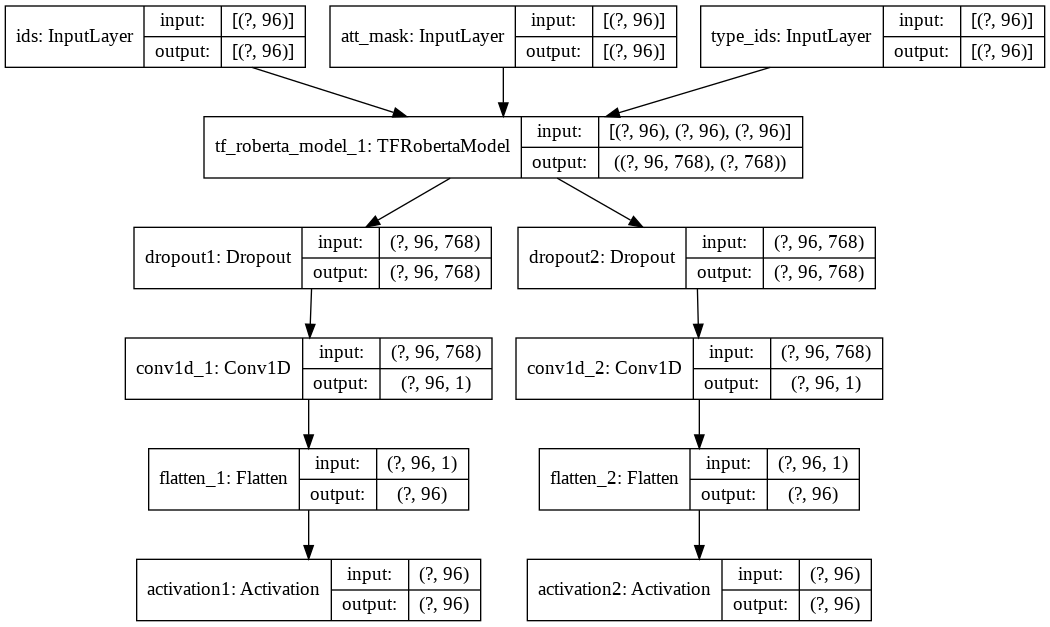

In [ ]:
tf.keras.utils.plot_model(model1, 'Model1.png',show_shapes=True)

In [ ]:
#Creating  directory for model and weights 
import os
import shutil

shutil.rmtree('/content/Model1')
shutil.rmtree('/content/model_save')

os.mkdir('/content/Model1')
os.mkdir('/content/model_save')

In [ ]:
#Setting the parameters for TensorBoard
from tensorflow.keras.callbacks import TensorBoard
%load_ext tensorboard
!rm -rf ./logs/ 

log_dir='/content/Model1'
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
#Checkpoint to store the weights
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint=ModelCheckpoint('/content/model_save/roberta.h5', monitor='val_loss', verbose=1, save_best_only=True,
        save_weights_only=True, mode='auto', save_freq='epoch')

In [ ]:
#Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
model1.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [ ]:
#Fitting the model and running it for 4 epochs
callback=[tensorboard_callback,checkpoint]
model1.fit([X_tr1,X_tr2,X_tr3],[Y_tr1,Y_tr2],
           validation_data=([X_val1,X_val2,X_val3],[Y_val1,Y_val2]),
           batch_size=32,epochs=4,callbacks=callback)

Epoch 1/4
550/550 [==============================] - ETA: 0s - loss: 2.5168 - activation1_loss: 1.2381 - activation2_loss: 1.2787
Epoch 00001: val_loss improved from inf to 1.69221, saving model to /content/model_save/roberta.h5
550/550 [==============================] - 886s 2s/step - loss: 2.5168 - activation1_loss: 1.2381 - activation2_loss: 1.2787 - val_loss: 1.6922 - val_activation1_loss: 0.8698 - val_activation2_loss: 0.8224
Epoch 2/4
550/550 [==============================] - ETA: 0s - loss: 1.7021 - activation1_loss: 0.8762 - activation2_loss: 0.8259
Epoch 00002: val_loss improved from 1.69221 to 1.67118, saving model to /content/model_save/roberta.h5
550/550 [==============================] - 882s 2s/step - loss: 1.7021 - activation1_loss: 0.8762 - activation2_loss: 0.8259 - val_loss: 1.6712 - val_activation1_loss: 0.8458 - val_activation2_loss: 0.8254
Epoch 3/4
550/550 [==============================] - ETA: 0s - loss: 1.5308 - activation1_loss: 0.7949 - activation2_loss: 0.7

In [ ]:
#Loading the tensorboard
%tensorboard --logdir '/content/Model1'

In [ ]:
#Model prediction on hold out test dataset
start,end=model1.predict([X_te1,X_te2,X_te3])

In [ ]:
def jaccard(str1, str2): 
  '''Returns the jaccard score for the given two strings '''
  a = set(str1.lower().split()) 
  b = set(str2.lower().split())
  c = a.intersection(b)
  return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
#Finds the selected text for the given tweet
def find_selected_text(data,tokenizer,start,end):
  '''Finds the selected text for the given tweet'''
  selected_text_list=[]
  for i in range(data.shape[0]):

    #Finding the start and end index
    start_idx=np.argmax(start[i])
    end_idx=np.argmax(end[i])
    

    #If start is greater than end index, predicted_text=text
    if (start_idx>end_idx):
      predicted_text=data.loc[i,'text']

    else:
      text1 = " "+" ".join(data.loc[i,'text'].split())
      tokens=tokenizer.encode(text1)
      predicted_text=tokenizer.decode(tokens.ids[start_idx-1:end_idx])        

    selected_text_list.append(predicted_text)

  return selected_text_list
    


In [ ]:
# Obtaining the predicted selected  text and adding to X_test dataframe
selected_text=find_selected_text(X_test,tokenizer,start,end)
X_test['predicted_text']=selected_text

for i,(_,row) in enumerate(X_test.iterrows()):
  X_test.loc[i,'jaccard']=jaccard(row.selected_text,row.predicted_text)

X_test.head(10)

,textID,text,selected_text,sentiment,predicted_text,jaccard
0,197aa929a2,misses driving already,misses driving already,negative,misses driving already,1.00
1,7648a76c96,Name the rest? Let`s see. Mystery Jets are pr...,cool.,positive,cool.,1.00
2,14fc34a4fb,anyways have a severe headache ryt now! i jst...,anyways have a severe headache ryt now! i jst ...,neutral,anyways have a severe headache ryt now! i jst...,1.00
3,50662e359b,25-man Ulduar is hard...,25-man Ulduar is hard...,neutral,25-man ulduar is hard...,1.00
4,b66219e011,Cried Like A Fukn Baby Today Durin Da Senior S...,Miss,negative,miss,1.00
5,6649f3558c,Not a prob hun,Not a prob,positive,not a prob hun,0.75
6,a54d3c2825,"I know It was worth a shot, though!",as wort,positive,worth,0.00
7,db83ff224e,You`re still welcome - the door`s wide enough...,You`re still welcome - the door`s wide enough ...,neutral,you`re still welcome - the door`s wide enough...,1.00
8,fdbaccd945,"_nickj07 Um....Nicks Voice,Smile,Eyes,Laugh,an...",Great,positive,great rolemodel,0.50
9,1c82fa1e65,reminds me of the weather a month ago it was ...,reminds me of the weather a month ago it was h...,neutral,reminds me of the weather a month ago it was ...,1.00


#### Error Analysis

In [ ]:
#Average Jaccard score for each sentiment

pos_average=np.mean(X_test['jaccard'][X_test['sentiment']=='positive'])
print('The average jaccard score for postive sentiment is  ',pos_average)

neg_average=np.mean(X_test['jaccard'][X_test['sentiment']=='negative'])
print('The average jaccard score for negative sentiment is  ',neg_average)

neu_average=np.mean(X_test['jaccard'][X_test['sentiment']=='neutral'])
print('The average jaccard score for neutral sentiment is  ',neu_average)

The average jaccard score for postive sentiment is   0.5238888596698996
The average jaccard score for negative sentiment is   0.5106560117678
The average jaccard score for neutral sentiment is   0.9767855342449009


In [ ]:
#Adding len of the selected text column

X_test['len_selected_text']=X_test['selected_text'].apply(lambda x: len(x.split()))
X_test['len_text']=X_test['text'].apply(lambda x: len(x.split()))
X_test['diff_len']=abs(X_test['len_selected_text']-X_test['len_text'])
X_test.head()

,textID,text,selected_text,sentiment,predicted_text,jaccard,len_selected_text,len_text,diff_len
0,197aa929a2,misses driving already,misses driving already,negative,misses driving already,1.0,3,3,0
1,7648a76c96,Name the rest? Let`s see. Mystery Jets are pr...,cool.,positive,cool.,1.0,1,20,19
2,14fc34a4fb,anyways have a severe headache ryt now! i jst...,anyways have a severe headache ryt now! i jst ...,neutral,anyways have a severe headache ryt now! i jst...,1.0,24,24,0
3,50662e359b,25-man Ulduar is hard...,25-man Ulduar is hard...,neutral,25-man ulduar is hard...,1.0,4,4,0
4,b66219e011,Cried Like A Fukn Baby Today Durin Da Senior S...,Miss,negative,miss,1.0,1,15,14


In [ ]:
#Total number of tweets with correct prediction and incorrect prediction
pos_jac_1=X_test[X_test['jaccard']==1]
pos_jac_0=X_test[X_test['jaccard']!=1]

In [ ]:
print('The total number of  tweets is',X_test.shape[0])
print('The total number of  tweets with jaccard=1 is',pos_jac_1.shape[0])
print('The total number of  tweets with jaccard not 1 is',pos_jac_0.shape[0])

The total number of  tweets is 4397
The total number of  tweets with jaccard=1 is 2457
The total number of  tweets with jaccard not 1 is 1940


In [ ]:
#Performance of model when both tweet and selected text is same

total_zero_diff=X_test[X_test['diff_len']==0].shape[0]
zero_diff_jaccard_1=pos_jac_1[pos_jac_1['diff_len']==0].shape[0]
result=zero_diff_jaccard_1*100/total_zero_diff
print('The percentage of  tweets with jaccard=1 when both tweet and selected text were same is',result)

The percentage of  tweets with jaccard=1 when both tweet and selected text were same is 83.31673306772909


In [ ]:
#Performance of model when difference between  tweet and selected text is less than 10

diff_less_10=X_test[X_test['diff_len']<=10].shape[0]
diff_less_10_jaccard_1=pos_jac_1[pos_jac_1['diff_len']<=10].shape[0]
result=diff_less_10_jaccard_1*100/diff_less_10
print('The percentage of tweets with jaccard=1 when length difference is less than 10 is',result)

The percentage of tweets with jaccard=1 when length difference is less than 10 is 63.68083154998472


In [ ]:
#Performance of model when difference between  tweet and selected text is greter than 10 but less than 20

diff_less_20=X_test[(X_test['diff_len']>10) & (X_test['diff_len']<=20)].shape[0]
diff_less_20_jaccard_1=pos_jac_1[(pos_jac_1['diff_len']>10) & (pos_jac_1['diff_len']<=20)].shape[0]
result=diff_less_20_jaccard_1*100/diff_less_20
print('The percentage of tweets with jaccard=1 when length difference is greter than 10 and less than 20 is',result)

The percentage of tweets with jaccard=1 when length difference is greter than 10 and less than 20 is 31.53759820426487


In [ ]:
#Performance of model when difference between  tweet and selected text is greter than 20

diff_less_30=X_test[(X_test['diff_len']>20)].shape[0]
diff_less_30_jaccard_1=pos_jac_1[(pos_jac_1['diff_len']>20)].shape[0]
result=diff_less_30_jaccard_1*100/diff_less_30
print('The percentage of positive tweets with jaccard=1 when length difference is greter than 20 is',result)

The percentage of positive tweets with jaccard=1 when length difference is greter than 20 is 39.57446808510638


In [ ]:
#Mean of the jaccard score
print(np.mean(X_test['jaccard']))

0.7033813064360629


Conclusion
* The Roberta model performs well when the text and selected text are of same length.
* It does resonablly well when the difference between tweet selected text is of only few words but does not perform well when the difference increases.Although, the performance is much better than BERT QA model.

#### Prepare For Kaggle submission

In [ ]:
#Prepare data as required for BERT QA model

def computeTestData(data,tokenizer):  
  
    '''Prepare data as required for ROBERTA model'''
    
    row = data.shape[0]
    input_ids = np.ones((row,MAX_LEN),dtype='int32')
    attention_mask = np.zeros((row,MAX_LEN),dtype='int32')
    token_type_ids = np.zeros((row,MAX_LEN),dtype='int32')
    
    for k in range(row):
        text=" "+" ".join(data.loc[k,'text'].split())
        enc=tokenizer.encode(text)
        s_tok = sentiment_id[data.loc[k,'sentiment']]

        input_ids[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_tok] + [2]
        attention_mask[k,:len(enc.ids)+5] = 1
        
    return (input_ids,attention_mask,token_type_ids)


In [ ]:
#Applying the above methods on test dataset

test1,test2,test3=computeTestData(test,tokenizer)

In [ ]:
#Prediction on test dataset
start,end=model1.predict([test1,test2,test3])

In [ ]:
#Find the selected text and create the submission file

selected_text=find_selected_text(test,tokenizer,start,end)
submission=pd.DataFrame(columns=['textID','selected_text'])
submission['textID']=test['textID']
submission['selected_text']=selected_text

submission.to_csv('/kaggle/working/submission.csv',index=False)

Kaggle Score
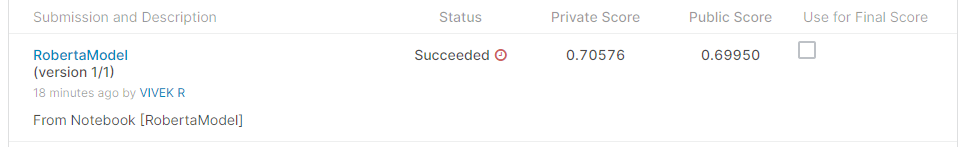

### QueryPerSecond calculation

In [ ]:
#Calculate number of queries executed per second
import time

def calculateTime(X_te1,X_te2,X_te3,X_test,tokenizer):
  start_time=time.time()  

  start,end=model1.predict([X_te1,X_te2,X_te3])
  selected_text=find_selected_text(X_test,tokenizer,start,end)
  X_test['predicted_text']=selected_text
  for i,(_,row) in enumerate(X_test.iterrows()):
    X_test.loc[i,'jaccard']=jaccard(row.selected_text,row.predicted_text)

  end_time=time.time()
  
  diff=end_time-start_time

  print('Time difference is ',diff)

  return X_test


In [ ]:
X_test=calculateTime(X_te1,X_te2,X_te3,X_test,tokenizer)

Time difference is  33.053561210632324


In [ ]:
print('Total number of queries executed in 33s is ',X_test.shape[0])
print('Number of queries executed per second is ',X_test.shape[0]/33)

Total number of queries executed in 33s is  4397
Number of queries executed per second is  133.24242424242425


In [ ]:
# Obtaining the predicted selected  text and adding to X_test dataframe
selected_text=find_selected_text(X_test,tokenizer,start,end)
X_test['predicted_text']=selected_text

for i,(_,row) in enumerate(X_test.iterrows()):
  X_test.loc[i,'jaccard']=jaccard(row.selected_text,row.predicted_text)

X_test.head(10)

,textID,text,selected_text,sentiment,predicted_text,jaccard
0,197aa929a2,misses driving already,misses driving already,negative,misses,0.333333
1,7648a76c96,Name the rest? Let`s see. Mystery Jets are pr...,cool.,positive,pretty cool.,0.500000
2,14fc34a4fb,anyways have a severe headache ryt now! i jst...,anyways have a severe headache ryt now! i jst ...,neutral,anyways have a severe headache ryt now! i jst...,1.000000
3,50662e359b,25-man Ulduar is hard...,25-man Ulduar is hard...,neutral,25-man ulduar is hard...,1.000000
4,b66219e011,Cried Like A Fukn Baby Today Durin Da Senior S...,Miss,negative,cried like a fukn baby today durin da senior ...,0.090909
5,6649f3558c,Not a prob hun,Not a prob,positive,not a prob hun,0.750000
6,a54d3c2825,"I know It was worth a shot, though!",as wort,positive,"worth a shot, though!",0.000000
7,db83ff224e,You`re still welcome - the door`s wide enough...,You`re still welcome - the door`s wide enough ...,neutral,you`re still welcome - the door`s wide enough...,1.000000
8,fdbaccd945,"_nickj07 Um....Nicks Voice,Smile,Eyes,Laugh,an...",Great,positive,great rolemodel,0.500000
9,1c82fa1e65,reminds me of the weather a month ago it was ...,reminds me of the weather a month ago it was h...,neutral,reminds me of the weather a month ago it was ...,1.000000


#### Error Analysis

In [ ]:
#Average Jaccard score for each sentiment

pos_average=np.mean(X_test['jaccard'][X_test['sentiment']=='positive'])
print('The average jaccard score for postive sentiment is  ',pos_average)

neg_average=np.mean(X_test['jaccard'][X_test['sentiment']=='negative'])
print('The average jaccard score for negative sentiment is  ',neg_average)

neu_average=np.mean(X_test['jaccard'][X_test['sentiment']=='neutral'])
print('The average jaccard score for neutral sentiment is  ',neu_average)

The average jaccard score for postive sentiment is   0.5097252664116794
The average jaccard score for negative sentiment is   0.5097481581628335
The average jaccard score for neutral sentiment is   0.9778607660485775


In [ ]:
#Adding len of the selected text column

X_test['len_selected_text']=X_test['selected_text'].apply(lambda x: len(x.split()))
X_test['len_text']=X_test['text'].apply(lambda x: len(x.split()))
X_test['diff_len']=abs(X_test['len_selected_text']-X_test['len_text'])
X_test.head()

,textID,text,selected_text,sentiment,predicted_text,jaccard,len_selected_text,len_text,diff_len
0,197aa929a2,misses driving already,misses driving already,negative,misses,0.333333,3,3,0
1,7648a76c96,Name the rest? Let`s see. Mystery Jets are pr...,cool.,positive,pretty cool.,0.500000,1,20,19
2,14fc34a4fb,anyways have a severe headache ryt now! i jst...,anyways have a severe headache ryt now! i jst ...,neutral,anyways have a severe headache ryt now! i jst...,1.000000,24,24,0
3,50662e359b,25-man Ulduar is hard...,25-man Ulduar is hard...,neutral,25-man ulduar is hard...,1.000000,4,4,0
4,b66219e011,Cried Like A Fukn Baby Today Durin Da Senior S...,Miss,negative,cried like a fukn baby today durin da senior ...,0.090909,1,15,14


In [ ]:
#Total number of tweets with correct prediction and incorrect prediction
pos_jac_1=X_test[X_test['jaccard']==1]
pos_jac_0=X_test[X_test['jaccard']!=1]

In [ ]:
print('The total number of  tweets is',X_test.shape[0])
print('The total number of  tweets with jaccard=1 is',pos_jac_1.shape[0])
print('The total number of  tweets with jaccard not 1 is',pos_jac_0.shape[0])

The total number of  tweets is 4397
The total number of  tweets with jaccard=1 is 2396
The total number of  tweets with jaccard not 1 is 2001


In [ ]:
#Performance of model when both tweet and selected text is same

total_zero_diff=X_test[X_test['diff_len']==0].shape[0]
zero_diff_jaccard_1=pos_jac_1[pos_jac_1['diff_len']==0].shape[0]
result=zero_diff_jaccard_1*100/total_zero_diff
print('The percentage of  tweets with jaccard=1 when both tweet and selected text were same is',result)

The percentage of  tweets with jaccard=1 when both tweet and selected text were same is 85.10956175298804


In [ ]:
#Performance of model when difference between  tweet and selected text is less than 10

diff_less_10=X_test[X_test['diff_len']<=10].shape[0]
diff_less_10_jaccard_1=pos_jac_1[pos_jac_1['diff_len']<=10].shape[0]
result=diff_less_10_jaccard_1*100/diff_less_10
print('The percentage of tweets with jaccard=1 when length difference is less than 10 is',result)

The percentage of tweets with jaccard=1 when length difference is less than 10 is 63.161112809538366


In [ ]:
#Performance of model when difference between  tweet and selected text is greter than 10 but less than 20

diff_less_20=X_test[(X_test['diff_len']>10) & (X_test['diff_len']<=20)].shape[0]
diff_less_20_jaccard_1=pos_jac_1[(pos_jac_1['diff_len']>10) & (pos_jac_1['diff_len']<=20)].shape[0]
result=diff_less_20_jaccard_1*100/diff_less_20
print('The percentage of tweets with jaccard=1 when length difference is greter than 10 and less than 20 is',result)

The percentage of tweets with jaccard=1 when length difference is greter than 10 and less than 20 is 28.395061728395063


In [ ]:
#Performance of model when difference between  tweet and selected text is greter than 20

diff_less_30=X_test[(X_test['diff_len']>20)].shape[0]
diff_less_30_jaccard_1=pos_jac_1[(pos_jac_1['diff_len']>20)].shape[0]
result=diff_less_30_jaccard_1*100/diff_less_30
print('The percentage of positive tweets with jaccard=1 when length difference is greter than 20 is',result)

The percentage of positive tweets with jaccard=1 when length difference is greter than 20 is 32.765957446808514


In [ ]:
#Mean of the jaccard score
print(np.mean(X_test['jaccard']))

0.6991365818731822


Conclusion
* The Roberta model performs well when the text and selected text are of same length.
* It does resonablly well when the difference between tweet selected text is of only few words but does not perform well when the difference increases.Although, the performance is much better than BERT QA model.